### Analysis information

In [1]:
# Genotypes and colors for analyses
variants = ["mhk","Ihk","mAk","mhL","IAk","IhL","mAL","IAL"]
colors = ["red","orange","purple","green","blue","pink","violet","black"]
model_name = "3i"

### Imports

In [2]:
import lacmwc

import pandas as pd
import numpy as np
from scipy import optimize

from tqdm.auto import tqdm
import corner

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import patches

import re, os, glob, inspect, copy, glob, pickle

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title



### Function defintions

In [3]:
def fit_in_vivo(data_file,
                color="black",
                label=None,
                fig=None,
                ax=None):
    """
    Fit a hill model to an in vivo induction curve. Plot and return the 
    relative YFP at 1 nM, 1 uM, and 1 mM IPTG.
    
    Parameters
    ----------
    data_file : str
        data file with the aggregated results of in vivo experiments. expects
        iptg, fx_saturation, and fx_std_dev_true columns. 
    color : str
        color to use for this series
    label : str
        label for series
    fig : matplotlib.Figure
        figure for plot. if None, create one.
    ax : matplotlib.Axis
        axis for plot. if None, create one.
        
    Returns
    -------
    fig : matplotlib.Figure
        figure for plot
    ax : matplotlib.Axis
        axis for plot
    induct : list
        list of floats with hill model yfp at 1 nM, 1 uM, and 1 mM
    """

    def _hill(x,k,n,yfp_min,yfp_max):
    
        return yfp_max*(x**n)/(k + x**n) + yfp_min

    def _hill_residual(param,x,y):

        return _hill(x,param[0],param[1],param[2],param[3]) - y
    

    df = pd.read_csv(data_file)
    drop_columns = [c for c in df.columns if c.startswith("Unnamed: ") or c == "index"]
    if len(drop_columns) > 0:
        df = df.drop(columns=drop_columns)

    # Convert to molar
    df.iptg = df.iptg/1e9

    if fig is None:
        fig, ax = plt.subplots(1,figsize=(6,6))

    ax.plot(df.iptg,df.fx_saturation,"o",color=color,label=label)
    ax.errorbar(df.iptg,
                df.fx_saturation,
                df.fx_std_dev_true/np.sqrt(3),
                lw=0,
                elinewidth=1,
                capsize=2,
                color=color)

    fit = optimize.least_squares(_hill_residual,
                                 x0=[1e-6,1,0,1],
                                 args=(df.iptg,df.fx_saturation))
    x_span = 10**np.linspace(-9.2,-1.8,500)
    values = _hill(x_span,*fit.x)
    ax.plot(x_span,values,"-",lw=2,color=color)

    induct = [_hill(1e-9,*fit.x),
              _hill(1e-6,*fit.x),
              _hill(1e-3,*fit.x)]
    
    return fig, ax, induct, values

def dG_bind(df,RT=(0.001987*298)):
    """
    Calculate the binding free energy for the repressor binding to operator.
    
    Parameters
    ----------
    df : pandas.DataFrame
        datafrme with all species concentrations for individual MCMC
        replicates. 
    RT : float
        R*T
    
    Returns
    -------
    dG_bind : numpy.ndarray
        float array with dG_bind for each row in the dataframe. 
    """
    
    prot_bound =    np.sum(df.loc[:,["H.O","H.O.I_2","L.O","L.O.I_2"]],axis=1)
    prot_bound += 2*np.sum(df.loc[:,["H.O.I","L.O.I"]],axis=1)
    
    prot_free =    np.sum(df.loc[:,["H","H.I_2","L","L.I_2"]],axis=1)
    prot_free += 2*np.sum(df.loc[:,["H.I","L.I"]],axis=1)
    oper_free = np.sum(df.loc[:,["O"]],axis=1)
    
    return -RT*np.log(prot_bound/(prot_free*oper_free))

def get_converged(df,converge_criterion=1.2e-8):
    """
    Get whether or not estimates have converged at both an individual 
    replicate/condition level and at the level of whole replicates.
    Creates new "converged" and "rep_converged" columns. 
    
    Parameters
    ----------
    df : pandas.DataFrame
        dataframe with all species concentrations for individual MCMC
        replicates
    converge_criterion : float, default=1.2e-8
        total concentration of all protein species must be within this 
        molar concentraiton of the total. 
    
    Returns
    -------
    df : pandas.DataFrame
        dataframe with new converged and rep_converged columns
    """

    col = ["H","L","H.I","H.I_2","H.O","H.O.I","H.O.I_2","L.I","L.I_2","L.O","L.O.I","L.O.I_2"]
    
    converged = np.abs(df.loc[:,"prot_tot"] - np.sum(df.loc[:,col],axis=1)) <= 1.2e-8
    df["converged"] = converged
    df["rep_converged"] = False
    
    for rep in np.unique(df.replicate):
        mask = df.replicate == rep
        conv = np.unique(df.loc[mask,"converged"]) 
        if len(conv) == 1 and conv[0]:
            df.loc[mask,"rep_converged"] = True
        
    return df

def get_epistasis(dfs,
                  x_column,
                  y_column,
                  min_allowed=10,
                  num_pseudoreplicates=500,
                  rep_column="replicate"):
    """
    Get epistasis between values in y_column for set of genotypes
    
    Parameters
    ----------
    
    dfs: list
        list of four or eight dataframes that each have y_column and rep_column
            if 4 entries, df order: ab, Ab, aB, AB
            if 8 entires, df order: abc, Abc, aBc, abC, ABc, AbC, aBC, ABC
    x_column : str
        column with data for x on plot
    y_column : str
        column with data for y on plot
    rep_column : str
        column holding replicate number. function will calculate confidence
        given distribution of y_column values over all unique
        replicates
        
    Returns
    -------
    out : pandas.DataFrame
        dataframe with epistasis for each replicate as a function of x_column
    """
        
    if len(dfs) == 4:
        epistasis = "pairwise"
        names = ["00","10","01","11"]
    elif len(dfs) == 8:
        epistasis = "three-way"
        names = ["000","100","010","001","110","101","011","111"]
    else:
        err = "dfs must be a list of either four or eight dataframes\n"
        raise ValueError(err)
    
    # Create a set of pseudoreplicate replicates for the epistasis calculation. 
    # Sample each set of replicates, with replacement, to create identically 
    # sized dataframes containing only fully converged replicates. 
    s = []
    for i in range(len(dfs)):
        
        df = dfs[i]
        if "rep_converged" not in dfs[i].columns:
            df = get_converged(dfs[i].copy())
            
        df = df.loc[df.rep_converged,:]
        if len(df) < min_allowed:
            err = f"Less than {min_allowed} replicates are converged for dataframe {i}\n"
            raise RuntimeError(err)
            
        to_get = np.random.choice(np.unique(df.loc[:,rep_column]),
                                  num_pseudoreplicates,
                                  replace=True)
        tmp_df = []
        for j, rep in enumerate(to_get):
            mask = df.loc[:,rep_column] == rep
            this_df = df.loc[mask,:].copy()
            this_df.loc[:,rep_column] = j
            tmp_df.append(this_df)
        
        df = pd.concat(tmp_df,ignore_index=True)
        
        # If first time through loop, create output datframe
        if i == 0:
            out = df.loc[:,[rep_column,x_column]]
        
        out.loc[:,names[i]] = df.loc[:,y_column]
        
        
    if epistasis == "pairwise":
        ep = (out["11"] - out["01"]) - (out["10"] - out["00"])
    else:
        ep = out["111"] 
        ep -= (out["110"] + out["101"] + out["011"])
        ep += (out["100"] + out["010"] + out["001"]) 
        ep -= out["000"]
    
    out.loc[:,f"{y_column}_epistasis"] = ep
    
    out = out.sort_values(by=[rep_column,x_column])

    return out

def plot_curve(df,
               x_column,
               y_column,
               rep_column="replicate",
               area_cutoff=0.95,
               contour_levels=[0.682],
               color="black",
               median_fmt={"linestyle":"-","linewidth":3},
               area_fmt={"linestyle":"none","alpha":0.4},
               contour_fmt={"linestyle":"--","linewidth":1},
               fig=None,
               ax=None):
    """
    Plot a curve with uncertainty as areas/dashes.
    
    Parameters
    ----------
    df : pandas.DataFrame
        dataframe with x_column, y_column, and rep_column
    x_column : str
        column with data for x on plot
    y_column : str
        column with data for y on plot
    rep_column : str
        column holding replicate number. function will calculate confidence
        given distribution of y_column values over all unique replicates
    area_cutoff : float
        where to draw lines/areas for uncertainty. Is lower edge of two-
        tailed. Default is 95% confidence (0.025 below and 0.975 above). 
    contour_leveals : list
        draw lines at the specified contour levels (two-tailed). Deafult is
        0.682 (line at 1 standard deviation). 
    color : str
        color to use for plotting series
    median_fmt : dict
        pass these matplotlib keyword arguments to ax.plot(x,y) call for
        the median of the distribution.
    area_fmt : dict
        pass these matplotlib keyword arguments to matplotlib.patches.Polygon
        for each of the uncertainty areas
    contour_fmt : dict
        pass these matplotlib keyword arguments to ax.plot(x,y) call for the
        contour lines. 
    fig : matplotlib.Figure, optional
        fig on which to do plot. if None, create new. 
    ax : matplotlib.Axis, optional
        ax on which to do plot. if None, create new
    
    Returns
    -------
    fig, ax : matplotlib.Figure, matplotlib.ax
        matplotlib objects used for potting. 
    """
    
    # Work on copies of input dictionaies
    median_fmt = copy.deepcopy(median_fmt)
    area_fmt = copy.deepcopy(area_fmt)
    contour_fmt = copy.deepcopy(contour_fmt)
    
    # This allows user to specify a partial dictionary of formats without 
    # having to pass entire formatter with all defaults. If a dictionary 
    # is passed without one of the default arguments, this is added in. 
    to_add_default = {"median_fmt":median_fmt,
                      "area_fmt":area_fmt,
                      "contour_fmt":contour_fmt}
    for d in to_add_default:
        
        # Get default for this parameter. 
        default = inspect.signature(plot_curve).parameters[d].default
        
        # Go through keys in the default dictionary and update the argument
        # passed in by the user with those defaults. 
        for k in default:
            try:
                to_add_default[d][k]
            except KeyError:
                to_add_default[d][k] = default[k]
        
    # If user hasn't specified unique colors for each element, use the main
    # color
    try:
        median_fmt["color"]
    except KeyError:
        median_fmt["color"] = color
        
    try:
        area_fmt["facecolor"]
    except KeyError:
        area_fmt["facecolor"] = color
        
    try:
        contour_fmt["color"]
    except KeyError:
        contour_fmt["color"] = color
    
    # Create figure if needed
    if fig is None:
        fig, ax = plt.subplots(1,figsize=(6,6))
    
    # Make a stack of the y values vs. x
    reps = np.unique(df.loc[:,rep_column])
    y_stack = []
    for r in reps:
        x = np.array(df.loc[df.replicate == r,x_column])
        y_stack.append(df.loc[df.replicate == r,y_column])

    y_stack = np.array(y_stack)

    cutoffs = [(1-area_cutoff)/2]
    if contour_levels is not None:
        for c in contour_levels:
            cutoffs.append((1-c)/2)
    
    # Calculate edges for cutoffs, as well as grabbing mean
    median_y = []
    lows = [[] for _ in range(len(cutoffs))]
    highs = [[] for _ in range(len(cutoffs))]
    for i in range(y_stack.shape[1]):

        y = np.sort(y_stack[:,i])
        for j, c in enumerate(cutoffs):
            lows[j].append( y[int(round(    c*y.shape[0],0))])
            highs[j].append(y[int(round((1-c)*y.shape[0],0))])

        median_y.append(y[len(y)//2])

    # Plot median line
    median_y = np.array(median_y)    
    ax.plot(x,median_y,**median_fmt)
    
    # Create a polygon for the main area
    patch_x = list(x)
    patch_x.extend(patch_x[::-1])
    patch_x = np.array(patch_x)

    patch_y = lows[0]
    patch_y.extend(highs[0][::-1])
    patch_y = np.array(patch_y)

    patch_xy = np.array([patch_x,patch_y]).T

    area = patches.Polygon(patch_xy,**area_fmt)
    ax.add_patch(area)

    # Draw contour lines
    for i in range(1,len(cutoffs)):
        ax.plot(x,lows[i],**contour_fmt)
        ax.plot(x,highs[i],**contour_fmt)
    

    return fig, ax

## Analyze in vivo curves

### Fig 2

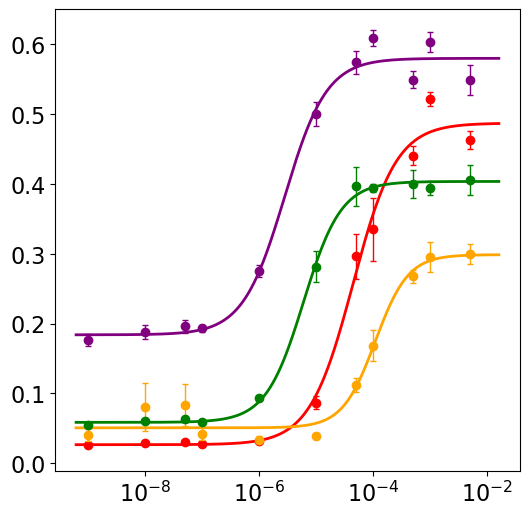

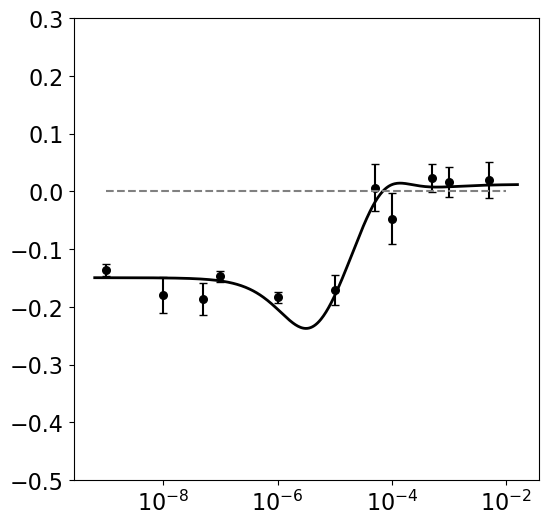

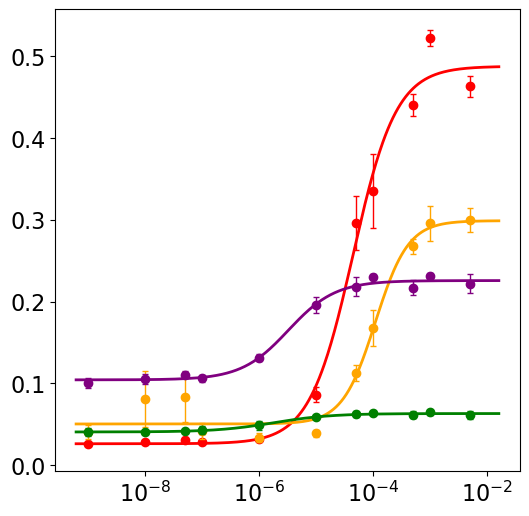

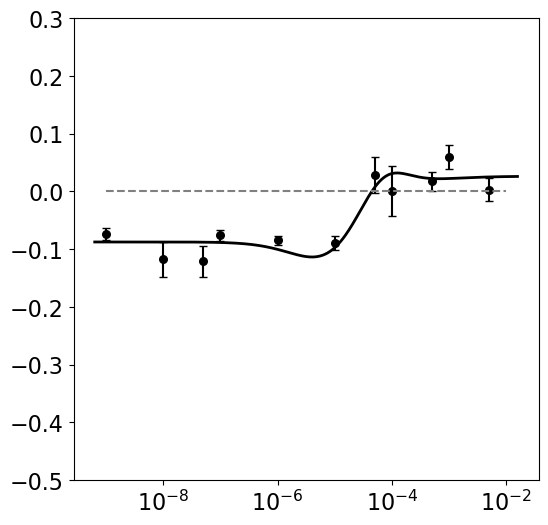

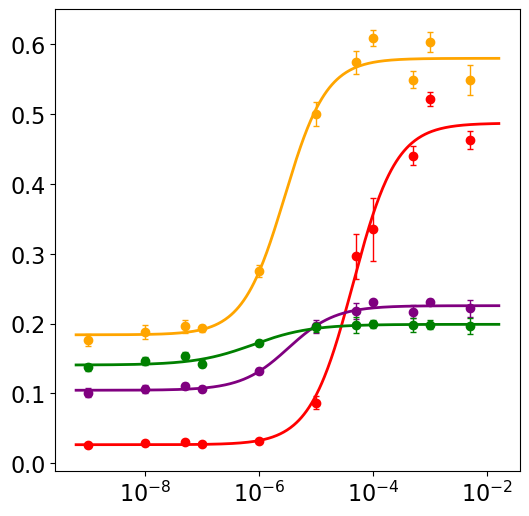

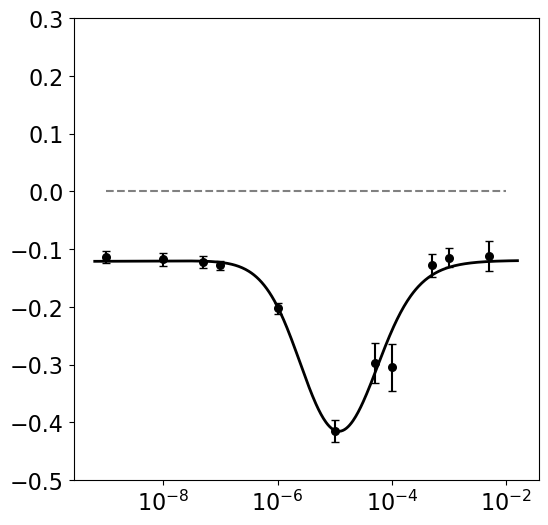

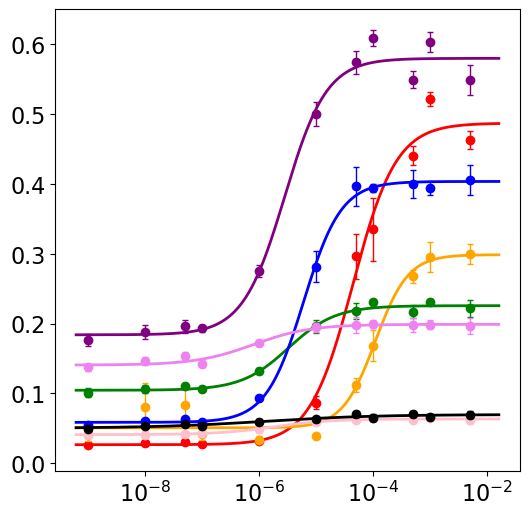

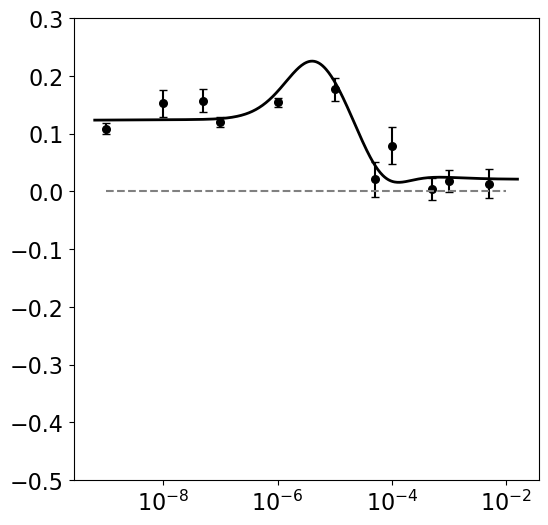

In [4]:

# 42/74, 42/84, 74/84, 42/74/84
cycle_sets = [["mhk","Ihk","mAk","IAk"],
              ["mhk","Ihk","mhL","IhL"],
              ["mhk","mAk","mhL","mAL"],
              ["mhk","Ihk","mAk","mhL","IAk","IhL","mAL","IAL"]]

for idx, cycle in enumerate(cycle_sets):
    
    fig, ax = None, None
    df_list = []
    fit_list = []
    for i in range(len(cycle)):
        cycle_file = f"data/in-vivo/{cycle[i]}.csv"

        fig, ax, induct, values = fit_in_vivo(cycle_file,
                                              color=colors[i],
                                              label=variants[i],
                                              fig=fig,
                                              ax=ax)
        
        df = pd.read_csv(cycle_file)
        
        df_list.append(df)
        fit_list.append(values)
        
    
    ax.set_xscale('log')
    plt.show()
    
    fig, ax = plt.subplots(1,figsize=(6,6))

    
    iptg = df.iptg*1e-9
    x_curve = 10**np.linspace(-9.2,-1.8,500)
    if len(df_list) == 4:
    
        ep = (df_list[3].fx_saturation - df_list[2].fx_saturation) - (df_list[1].fx_saturation - df_list[0].fx_saturation)
        ep_curve = (fit_list[3] - fit_list[2]) - (fit_list[1] - fit_list[0])
        
    else:
        ep = df_list[7].fx_saturation
        ep -= (df_list[4].fx_saturation + df_list[5].fx_saturation + df_list[6].fx_saturation)
        ep += (df_list[1].fx_saturation + df_list[2].fx_saturation + df_list[3].fx_saturation)
        ep -= df_list[0].fx_saturation
        
        ep_curve = fit_list[7]
        ep_curve -= (fit_list[4] + fit_list[5] + fit_list[6])
        ep_curve += (fit_list[1] + fit_list[2] + fit_list[3])
        ep_curve -= fit_list[0]
    
    
    err = None
    for i in range(len(df_list)):
        this_err = (df_list[i].fx_std_dev_true)**2
        if err is None:
            err = this_err
        else:
            err += this_err
            
    err = np.sqrt(err/len(df_list))
    
    ax.scatter(iptg,ep,s=30,color='black')
    ax.errorbar(iptg,ep,err,linestyle='none',capsize=3,color='black')
    
    ax.plot(x_curve,ep_curve,'-',lw=2,color='black')
    
    ax.plot((1e-9,1e-2),(0,0),'--',color='gray')
    ax.set_xscale('log')
    ax.set_ylim(-0.5,0.3)
    plt.show()
    
    

## Extract concs vs. IPTG

### Fig 3C

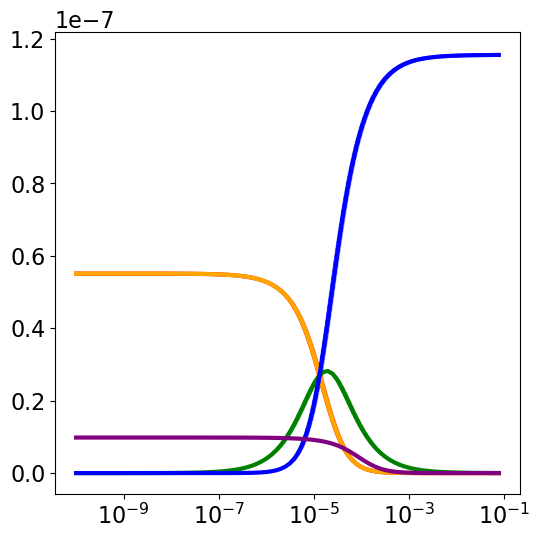

In [5]:
    
df = pd.read_csv(f"fit_{model_name}/mhk_concs.csv")
df = get_converged(df)
df = df.loc[df.rep_converged,:]

fig, ax = plot_curve(df,"iptg_tot","H",color="red")
fig, ax = plot_curve(df,"iptg_tot","L",fig=fig,ax=ax,color="orange")
fig, ax = plot_curve(df,"iptg_tot","L.I",fig=fig,ax=ax,color="green")
fig, ax = plot_curve(df,"iptg_tot","L.I_2",fig=fig,ax=ax,color="blue")
fig, ax = plot_curve(df,"iptg_tot","H.O",fig=fig,ax=ax,color="purple")
ax.set_xscale('log')


## Compare in vivo to free operator

### Fig 3D

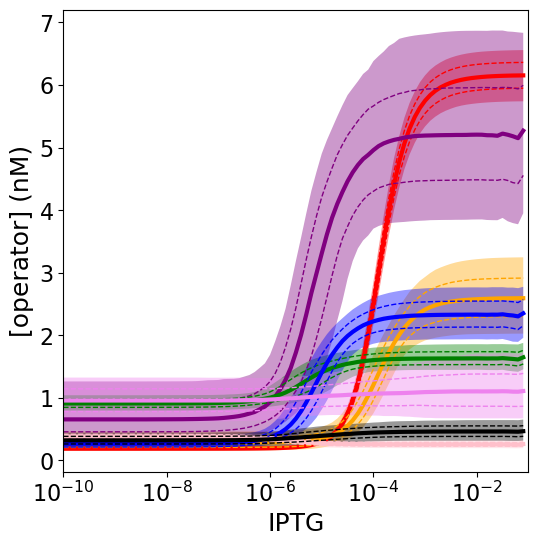

R2 0.963669656019193


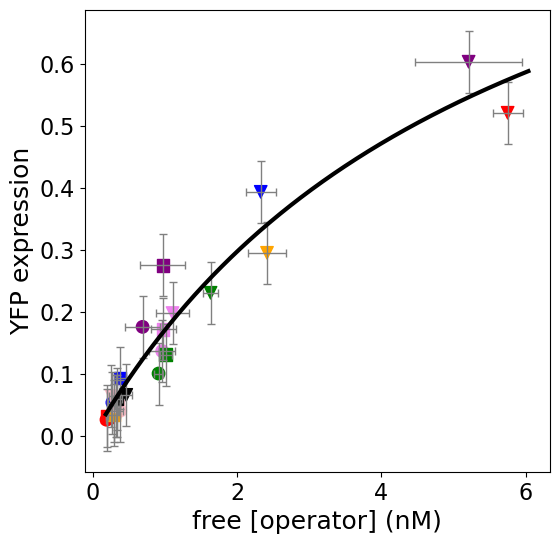

In [6]:

# Get in vivo data
out_df = {"variant":[],
          "nM":[],
          "uM":[],
          "mM":[]}
for v in variants:
    
    cycle_file = f"data/in-vivo/{v}.csv"
    df = pd.read_csv(cycle_file)
    
    out_df["variant"].append(v)
    out_df["nM"].append(np.array(df.loc[df.iptg == 1,"fx_saturation"])[0])
    out_df["uM"].append(np.array(df.loc[df.iptg == 1000,"fx_saturation"])[0])
    out_df["mM"].append(np.array(df.loc[df.iptg == 1000000,"fx_saturation"])[0])
    
in_vivo_induction_df = pd.DataFrame(out_df)



def _saturate(x,k,A):
    
    return A*(k*x/(1 + k*x))

def _saturate_residual(param,x,y):

    return _saturate(x,param[0],param[1]) - y

fig, ax = plt.subplots(1,figsize=(6,6))

out_df = {"variant":[],
          "nM":[],
          "nM_std":[],
          "uM":[],
          "uM_std":[],
          "mM":[],
          "mM_std":[]}

# Get in vitro data

for i in range(len(variants)):
    
    df = pd.read_csv(f"fit_{model_name}/{variants[i]}_concs.csv")
    df = get_converged(df)
    df = df.loc[df.rep_converged,:]
    df.loc[:,"O"] = df.loc[:,"O"]*1e9

    _ = plot_curve(df,
                   x_column="iptg_tot",
                   y_column="O",
                   fig=fig,
                   ax=ax,
                   color=colors[i],
                   median_fmt={"linestyle":"-","linewidth":3,"label":variants[i]}) 


    v_nM = df.loc[np.isclose(np.log10(df.iptg_tot),-9),"O"]
    v_uM = df.loc[np.isclose(np.log10(df.iptg_tot),-6),"O"]
    v_mM = df.loc[np.isclose(np.log10(df.iptg_tot),-3),"O"]
    
    out_df["variant"].append(variants[i])
    out_df["nM"].append(np.mean(v_nM))
    out_df["nM_std"].append(np.std(v_nM))
    out_df["uM"].append(np.mean(v_uM))
    out_df["uM_std"].append(np.std(v_uM))
    out_df["mM"].append(np.mean(v_mM))
    out_df["mM_std"].append(np.std(v_mM))
    
ax.set_xlabel("IPTG")
ax.set_ylabel("[operator] (nM)")
ax.set_xlim((1e-10,1e-1))
ax.set_xscale("log")
    
plt.show()


in_vitro_induction_df = pd.DataFrame(out_df)



    


fig, ax = plt.subplots(1,figsize=(6,6))
ax.errorbar(x=in_vitro_induction_df.nM,
            y=in_vivo_induction_df.nM,
            xerr=in_vitro_induction_df.nM_std,
            yerr=0.05,
            lw=0,
            elinewidth=1,
            capsize=3,
            color="gray")
ax.scatter(in_vitro_induction_df.nM,
           in_vivo_induction_df.nM,
           color=colors,
           marker="o",
           s=80)

ax.errorbar(x=in_vitro_induction_df.uM,
            y=in_vivo_induction_df.uM,
            xerr=in_vitro_induction_df.uM_std,
            yerr=0.05,
            lw=0,
            elinewidth=1,
            capsize=3,
            color="gray")
ax.scatter(in_vitro_induction_df.uM,
           in_vivo_induction_df.uM,
           color=colors,
           marker="s",
           s=80)

ax.errorbar(x=in_vitro_induction_df.mM,
            y=in_vivo_induction_df.mM,
            xerr=in_vitro_induction_df.mM_std,
            yerr=0.05,
            lw=0,
            elinewidth=1,
            capsize=3,
            color="gray")
ax.scatter(in_vitro_induction_df.mM,
           in_vivo_induction_df.mM,
           color=colors,
           marker="v",
           s=80)

all_in_vitro = list(in_vitro_induction_df.nM)
all_in_vitro.extend(in_vitro_induction_df.uM)
all_in_vitro.extend(in_vitro_induction_df.mM)
all_in_vitro = np.array(all_in_vitro)

all_in_vivo = list(in_vivo_induction_df.nM)
all_in_vivo.extend(in_vivo_induction_df.uM)
all_in_vivo.extend(in_vivo_induction_df.mM)
all_in_vivo = np.array(all_in_vivo)

fit = optimize.least_squares(_saturate_residual,
                             x0=[1,1],
                             args=(all_in_vitro,all_in_vivo))

x_span = np.linspace(np.min(all_in_vitro)*0.95,np.max(all_in_vitro)*1.05,500)
values = _saturate(x_span,*fit.x)

ax.plot(x_span,values,"-",lw=3,color="black")
ax.set_xlabel("free [operator] (nM)")
ax.set_ylabel("YFP expression")

SSR = np.sum(fit.fun**2)
SST = np.sum((all_in_vivo - np.min(all_in_vivo))**2)
print("R2",1 - SSR/SST)


## $\Delta G_{bind}$ vs. IPTG

### Fig 3E and 4A-D

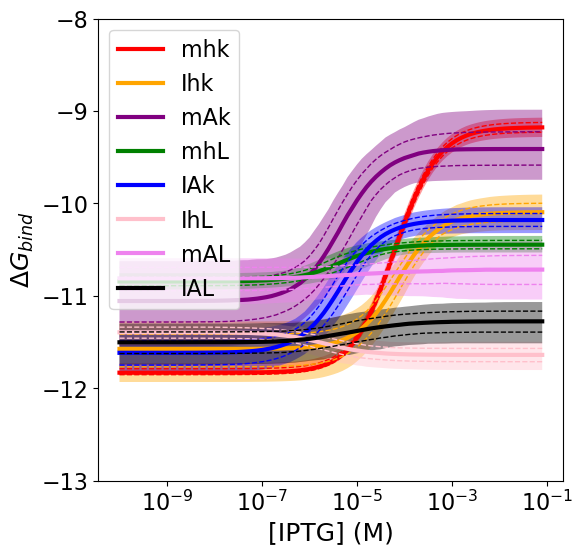

In [7]:

fig, ax = plt.subplots(1,figsize=(6,6))

for i in range(len(variants)):
    
    df = pd.read_csv(f"fit_{model_name}/{variants[i]}_concs.csv")
    drop_columns = [c for c in df.columns if c.startswith("Unnamed: ") or c == "index"]
    if len(drop_columns) > 0:
        df = df.drop(columns=drop_columns)

    df = get_converged(df)
    df = df.loc[df.rep_converged,:]
    
    df["dG_bind"] = dG_bind(df)
    
    fig, ax = plot_curve(df,
                         "iptg_tot",
                         "dG_bind",
                         color=colors[i],
                         median_fmt={"label":variants[i]},
                         fig=fig,
                         ax=ax)

ax.set_xscale("log")
ax.set_xlabel("[IPTG] (M)")
ax.set_ylabel("$ \Delta G _{bind} $")
ax.set_ylim((-13,-8))
ax.legend()



## Epistasis in $\Delta G_{bind}$

### Fig 4E-H

  0%|          | 0/4 [00:00<?, ?it/s]

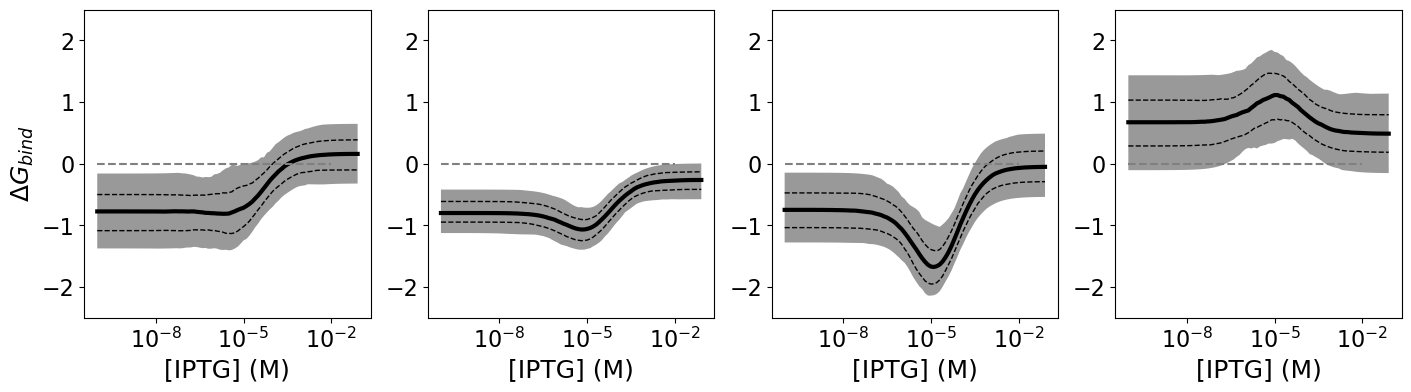

In [8]:
fig, ax = plt.subplots(1,4,figsize=(17,4))

# 42/74, 42/84, 74/84, 42/74/84
cycle_sets = [["mhk","Ihk","mAk","IAk"],
              ["mhk","Ihk","mhL","IhL"],
              ["mhk","mAk","mhL","mAL"],
              ["mhk","Ihk","mAk","mhL","IAk","IhL","mAL","IAL"]]

for i, cycle_files in enumerate(tqdm(cycle_sets)):
    cycle = [pd.read_csv(f"fit_{model_name}/{genotype}_concs.csv") for genotype in cycle_files]
    for j in range(len(cycle)):
        cycle[j]["dG_bind"] = dG_bind(cycle[j])
    ep_df = get_epistasis(cycle,x_column="iptg_tot",y_column="dG_bind")

    _ = plot_curve(ep_df,x_column="iptg_tot",y_column="dG_bind_epistasis",fig=fig,ax=ax[i])

    ax[i].set_xscale("log")
    ax[i].set_xlabel("[IPTG] (M)")
    
    if i == 0:
        ax[i].set_ylabel("$ \Delta G _{bind} $")

    ax[i].plot((1e-10,1e-2),(0,0),"--",color='gray')
    ax[i].set_ylim((-2.5,2.5))
        

## Epistasis in equilibrium constants

### Fig 5A-C

mhk-Ihk-mAk-IAk


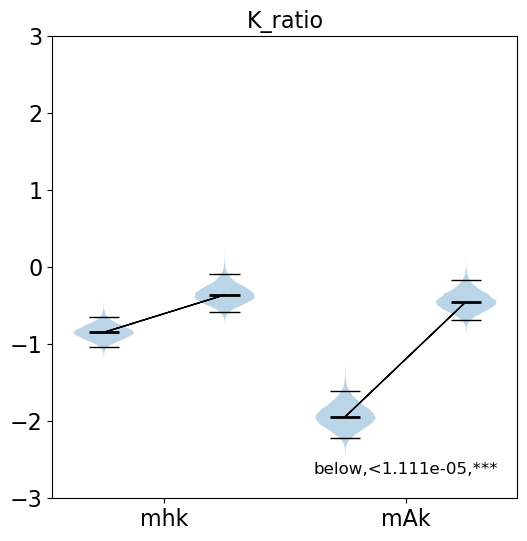

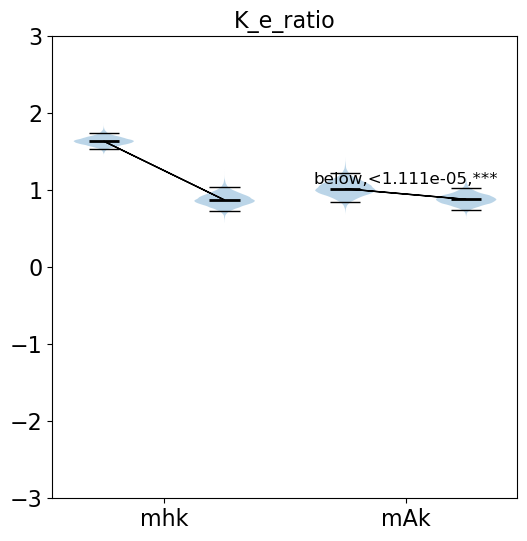

mhk-mAk-Ihk-IAk


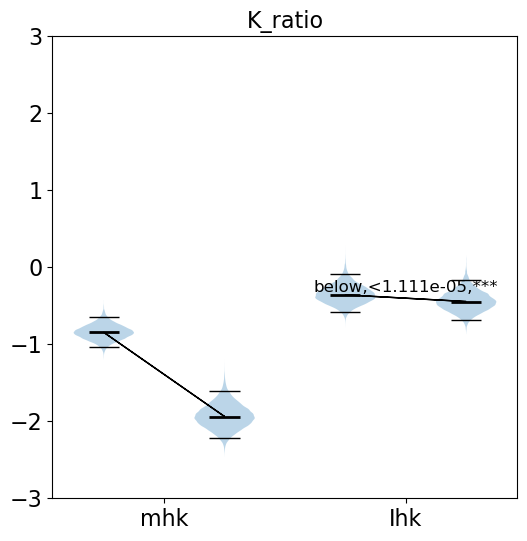

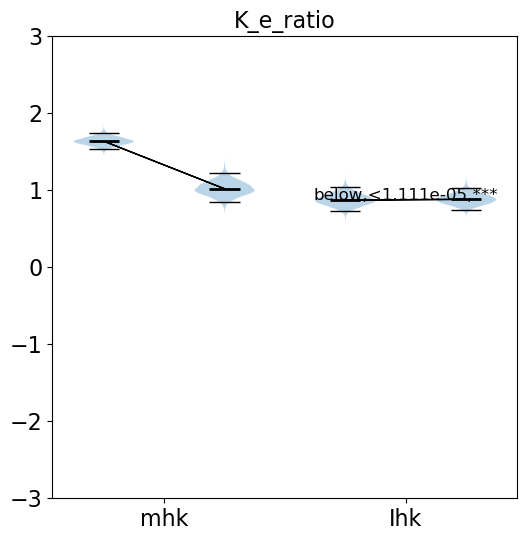

mhk-mAk-mhL-mAL


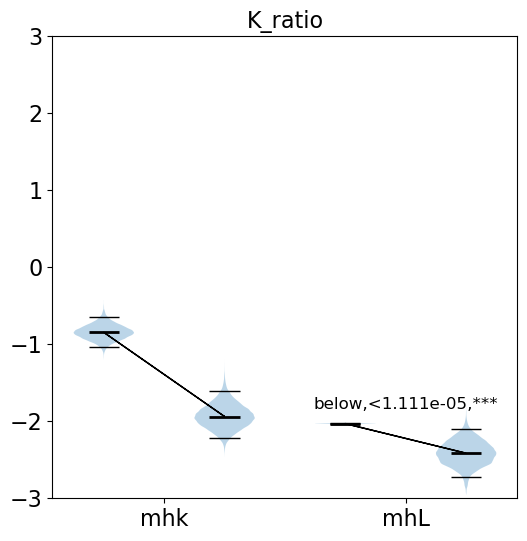

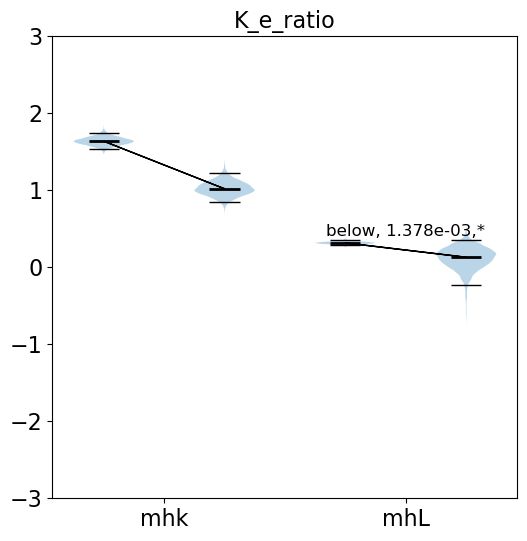

In [9]:
def plot_equilibrium_constant_epistasis(cycle):

    cycle_string = "-".join(cycle)
    print(cycle_string)
    
    out_dfs = {"K_ratio":{},
               "K_e_ratio":{}} 
    
    for i in range(len(cycle)):
        df = pd.read_csv(f"fit_{model_name}/{cycle[i]}.csv")
        df["K_e_ratio"] = df.loc[:,"K_rstar_e"] - df.loc[:,"K_r_e"]
        df = df.loc[:,["K_ratio","K_e_ratio"]]
        for k in out_dfs:
            out_dfs[k][cycle[i]] = np.array(df.loc[:,k])*0.001987*298

    all_y = []
    all_dy = []
    for k in out_dfs:

        out_dfs[k] = pd.DataFrame(out_dfs[k])

        df = out_dfs[k]
        medians = []
        lowers = []
        uppers = []
        all_values = []
        for c in df.columns:
            values = np.array(df.loc[:,c])
            values.sort()
            medians.append(values[len(values)//2])

            lower = np.round(len(values)*0.025,0)
            upper = np.round(len(values)*0.975,0)

            lowers.append(lower)
            uppers.append(upper)
            all_values.append(values)

        fig, ax = plt.subplots(1,figsize=(6,6))

        vp = ax.violinplot(df,
                           showextrema=False,
                           showmedians=True,
                           quantiles=[[0.025,0.975] for _ in range(len(df.columns))])

        vp["cmedians"].set_linewidth(2)
        vp["cmedians"].set_edgecolor("black")
        vp["cquantiles"].set_linewidth(1)
        vp["cquantiles"].set_edgecolor("black")

        xlabels = []
        for i in range(len(cycle)//2):
            x = 2*i + 1
            y = medians[2*i]
            dx = 1
            dy = medians[2*i + 1] - y

            ax.arrow(x,y,dx,dy,length_includes_head=True)

            xlabels.append(cycle[2*i])

            all_y.append((k,y))
            all_dy.append((k,dy))

            # Get distribution overlaps
            v2 = all_values[2*i].copy()
            v1 = all_values[2*i + 1].copy()

            np.random.shuffle(v1)
            np.random.shuffle(v2)

            eff = v2 - v1
            eff.sort()

            if i == 0:
                ref = eff
                continue

            higher = np.sum(eff > ref)
            lower = np.sum(eff < ref)

            if higher > lower:
                description = "above"
                p_value = 1 - higher/len(eff)
            else:
                description = "below"
                p_value = 1 - lower/len(eff)

            if p_value < 0.0001:
                code = "***"
            elif p_value < 0.001:
                code = "**"
            elif p_value < 0.01:
                code = "*"
            else:
                code = ""

            if p_value == 0.0:
                out = f"{description},<{1/len(eff):.3e},{code}"
            else:
                out = f"{description}, {p_value:.3e},{code}"


            ax.text(x+dx/2,y-dy/2,out,ha="center",size=12)


        ax.set_title(f"{k}")
        ax.set_ylim(-3,3)
        ax.set_xticks(np.arange(1,len(cycle)+1,2)+0.5)

        ax.set_xticklabels(xlabels)
    
        plt.show()

cycle = ["mhk","Ihk","mAk","IAk"]
plot_equilibrium_constant_epistasis(cycle)

cycle = ["mhk","mAk","Ihk","IAk"]
plot_equilibrium_constant_epistasis(cycle)

cycle = ["mhk","mAk","mhL","mAL"]
plot_equilibrium_constant_epistasis(cycle)


    
    

## Additive ensemble analyses

### Fig 5D-G

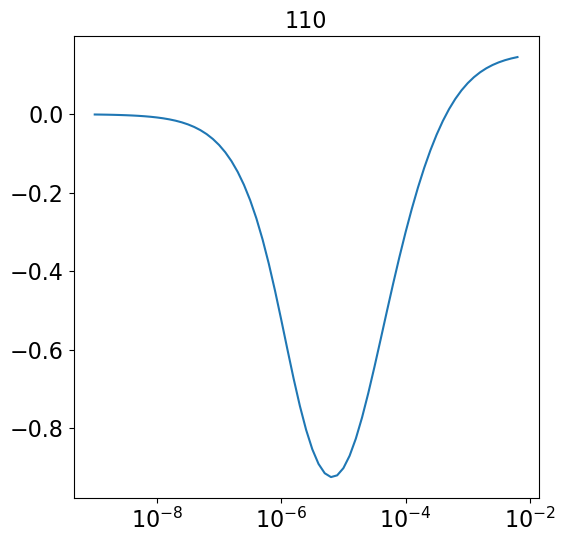

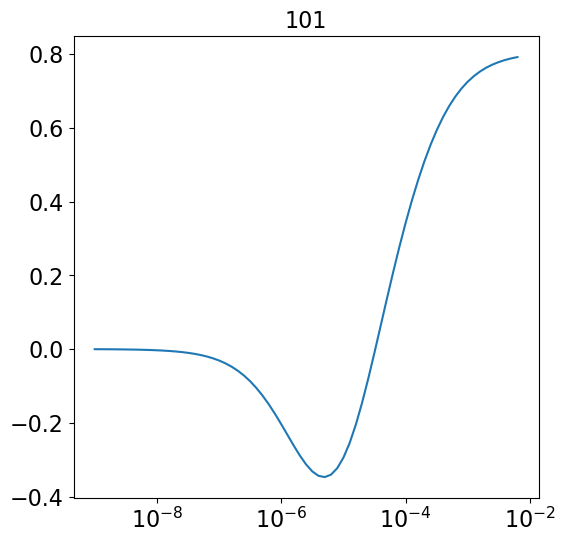

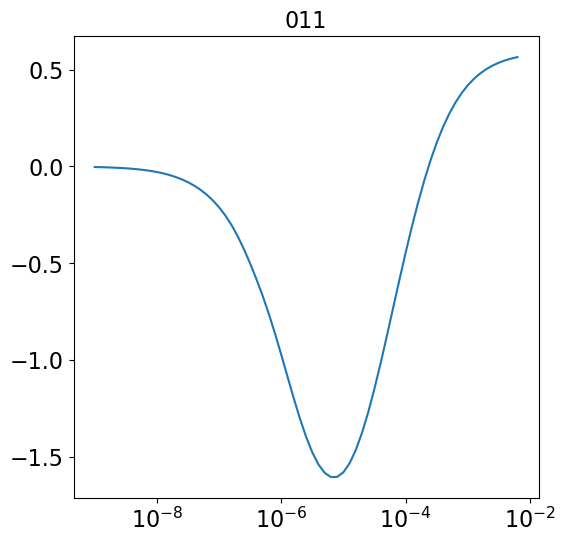

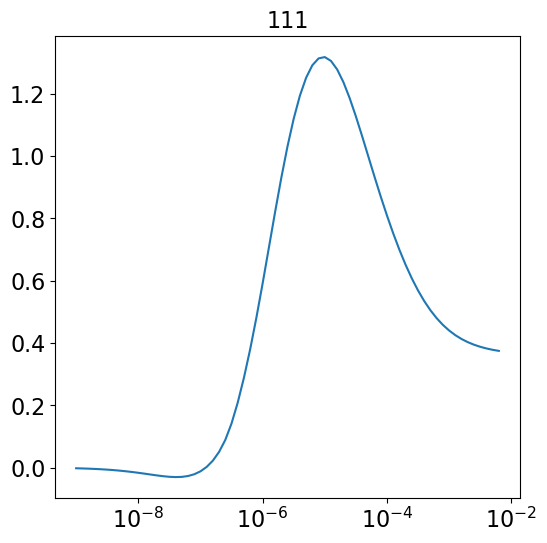

In [10]:
def calc_from_lnK(lnK_vector,
                  prot_tot=1.2e-7,
                  oper_tot=1e-8,
                  fig=None,
                  ax=None,
                  label=None,
                  color="black"):

    
    name_conversion = {"O":"O",
                       "E":"I",
                       "R":"H",
                       "Rstar":"L",
                       "RE":"H.I",
                       "RE2":"H.I_2",
                       "RO":"H.O",
                       "ROE":"H.O.I",
                       "ROE2":"H.O.I_2",
                       "RstarE":"L.I",
                       "RstarE2":"L.I_2",
                       "RstarO":"L.O",
                       "RstarOE":"L.O.I",
                       "RstarOE2":"L.O.I_2"}

    name_order = ["replicate",
                  "prot_tot","oper_tot","iptg_tot",
                  "O","I","H","L",
                  "H.I","H.I_2",
                  "H.O","H.O.I","H.O.I_2",
                  "L.I","L.I_2",
                  "L.O","L.O.I","L.O.I_2"]

    out_df = {}
    for i, iptg in enumerate(np.arange(-9,-2.1,0.1)):

        c_vector = np.array([prot_tot,oper_tot,10**(iptg)])*1e9
        out = lacmwc.model.LacMWC3().get_conc_dict(C_vector=c_vector,lnK_vector=lnK_vector)

        if i == 0:
            out_df["iptg_tot"] = [10**iptg]

            for k in out:
                out_df[name_conversion[k]] = [out[k]*1e-9]
        else:
            out_df["iptg_tot"].append(10**iptg)
            for k in out:
                out_df[name_conversion[k]].append(out[k]*1e-9)

    df = pd.DataFrame(out_df)
    df["replicate"] = 1
    df["prot_tot"] = prot_tot
    df["oper_tot"] = oper_tot
    df = df.loc[:,name_order]
    df["dG_bind"] = dG_bind(df)
    
    
    return df

    
def plot_additive_epistasis(mutant_lnK):
    
    all_df = []
    for i, m in enumerate(mutant_lnK):
        df = calc_from_lnK(lnK_vector=mutant_lnK[m],label=m,color=colors[i])
        all_df.append(df)

    fig, ax = plt.subplots(1,figsize=(6,6))
    
    if len(mutant_lnK) == 4:
        ep = (all_df[3]["dG_bind"] - all_df[1]["dG_bind"]) - (all_df[2]["dG_bind"] - all_df[0]["dG_bind"]) 
    else:
        ep = all_df[7]["dG_bind"]
        ep -= (all_df[6]["dG_bind"] + all_df[5]["dG_bind"] + all_df[4]["dG_bind"])
        ep += (all_df[3]["dG_bind"] + all_df[2]["dG_bind"] + all_df[1]["dG_bind"]) 
        ep -= all_df[0]["dG_bind"]

    ax.plot(all_df[3].iptg_tot,ep)
    ax.set_xscale('log')
    
    return fig, ax
    


def _get_median(csv_file):
    
    df = pd.read_csv(csv_file)
    
    out = []
    for k in ["K_ratio","K_r_e","K_rstar_e"]:
        v = np.array(df.loc[:,k])
        v.sort()
        out.append(v[len(v)//2])
        
    return np.array(out)
    
    
# Get additive effects
wt = _get_median(f"fit_{model_name}/mhk.csv")
m42I = _get_median(f"fit_{model_name}/Ihk.csv") - wt
h74A = _get_median(f"fit_{model_name}/mAk.csv") - wt
k84L = _get_median(f"fit_{model_name}/mhL.csv") - wt
    
est_lnK = {"wt":wt,
           "m42I":m42I,
           "h74A":h74A,
           "k84L":k84L}

# 110
mutant_lnK = {"mhk":est_lnK["wt"],
              "Ihk":est_lnK["wt"] + est_lnK["m42I"],
              "mAk":est_lnK["wt"] + est_lnK["h74A"],
              "IAk":est_lnK["wt"] + est_lnK["m42I"] + est_lnK["h74A"],
             }
fig, ax = plot_additive_epistasis(mutant_lnK)
ax.set_title("110")

# 101
mutant_lnK = {"mhk":est_lnK["wt"],
              "Ihk":est_lnK["wt"] + est_lnK["m42I"],
              "mhL":est_lnK["wt"] + est_lnK["k84L"],
              "IhL":est_lnK["wt"] + est_lnK["m42I"] + est_lnK["k84L"],
             }
fig, ax = plot_additive_epistasis(mutant_lnK)
ax.set_title("101")

# 011
mutant_lnK = {"mhk":est_lnK["wt"],
              "mAk":est_lnK["wt"] + est_lnK["h74A"],
              "mhL":est_lnK["wt"] + est_lnK["k84L"],
              "mAL":est_lnK["wt"] + est_lnK["h74A"] + est_lnK["k84L"],
             }
fig, ax = plot_additive_epistasis(mutant_lnK)
ax.set_title("011")


# 111
mutant_lnK = {"mhk":est_lnK["wt"],
              "Ihk":est_lnK["wt"] + est_lnK["m42I"],
              "mAk":est_lnK["wt"] + est_lnK["h74A"],
              "mhL":est_lnK["wt"] + est_lnK["k84L"],
              "IAk":est_lnK["wt"] + est_lnK["m42I"] + est_lnK["h74A"],
              "IhL":est_lnK["wt"] + est_lnK["m42I"] + est_lnK["k84L"],
              "mAL":est_lnK["wt"] + est_lnK["h74A"] + est_lnK["k84L"],
              "IAL":est_lnK["wt"] + est_lnK["m42I"] + est_lnK["h74A"] + est_lnK["k84L"]
             }

fig, ax = plot_additive_epistasis(mutant_lnK)
ax.set_title("111")
None


## Ensemble population plots

### Fig 6A-D

mhk


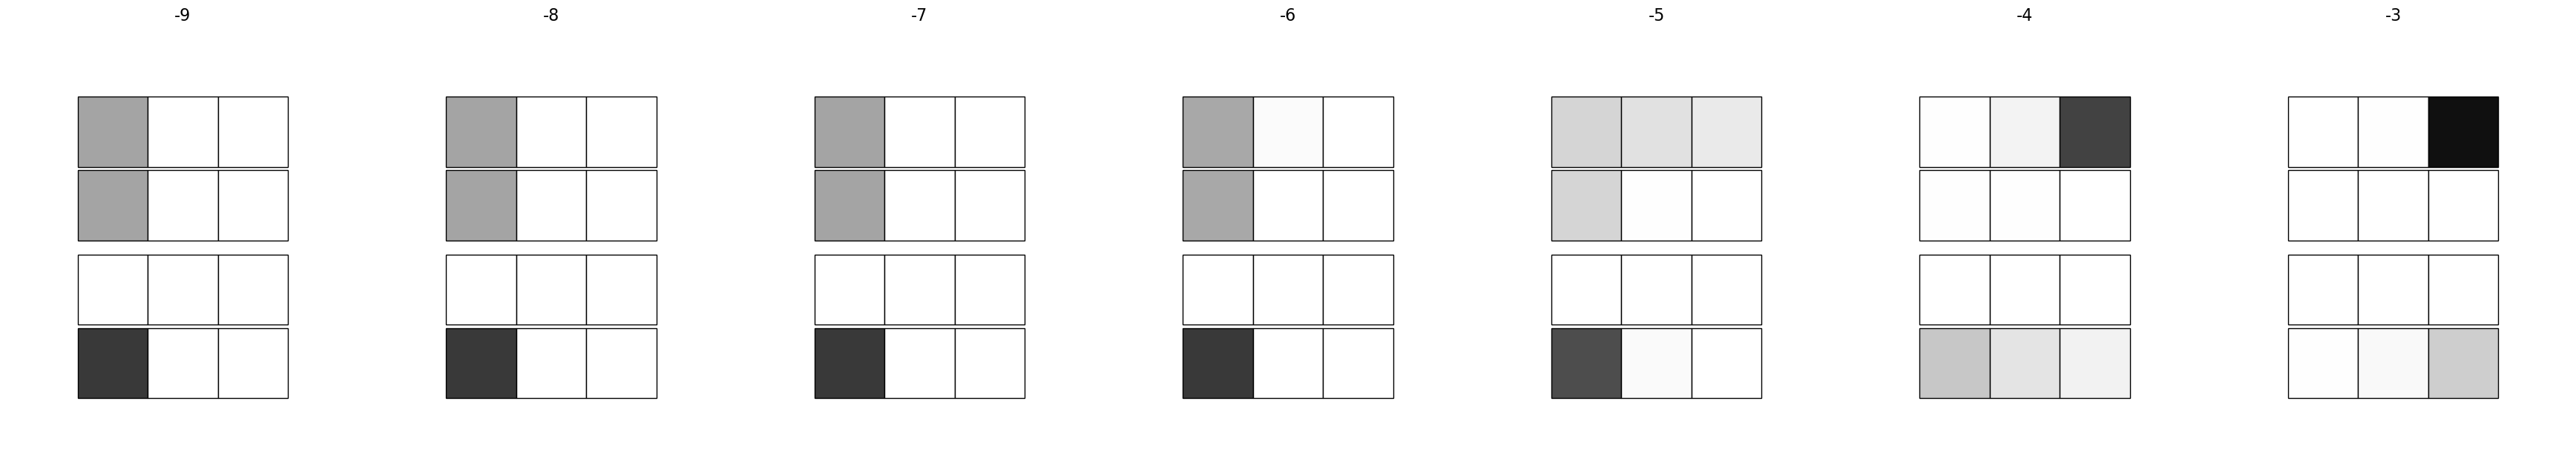

Ihk


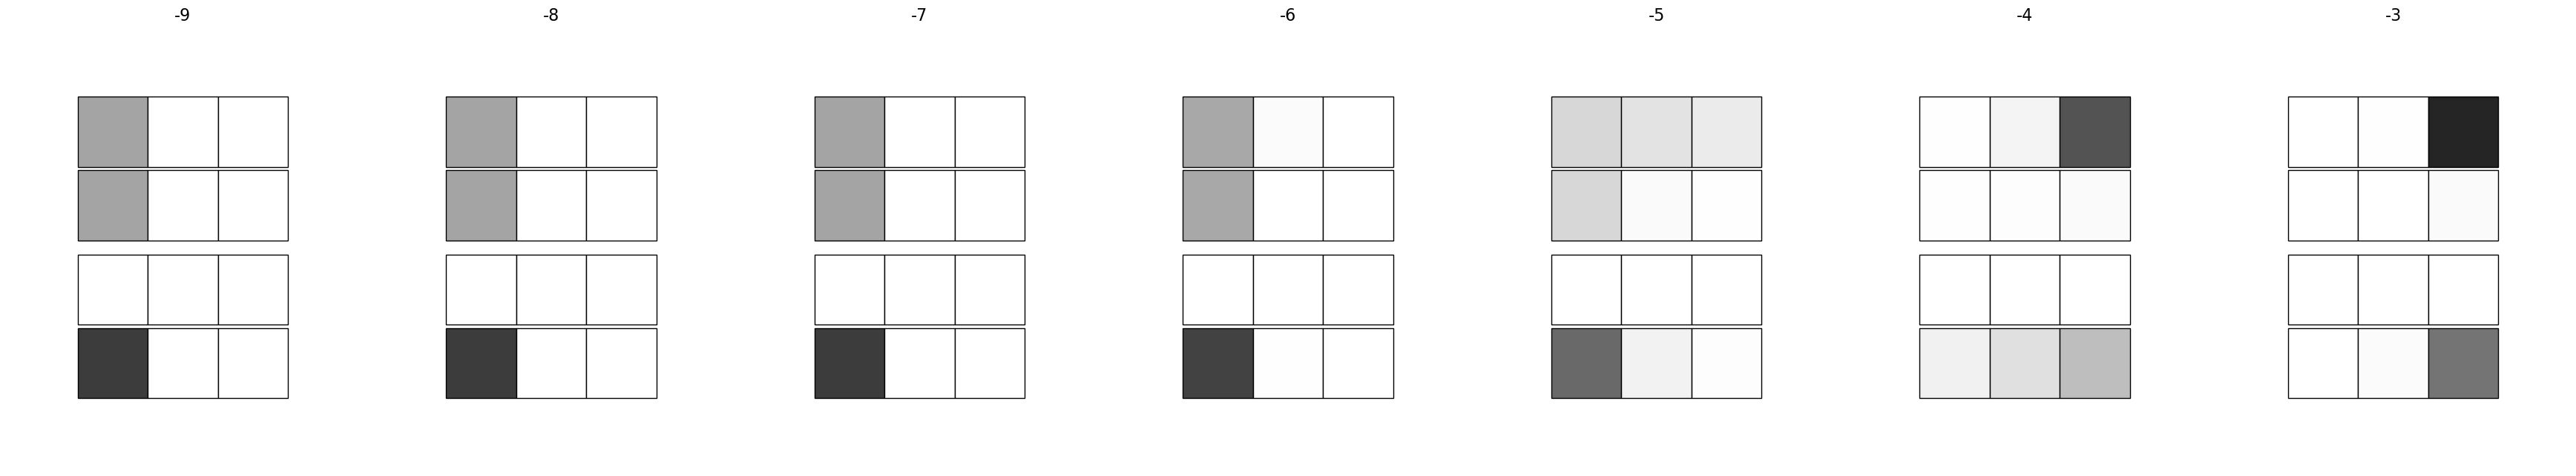

mAk


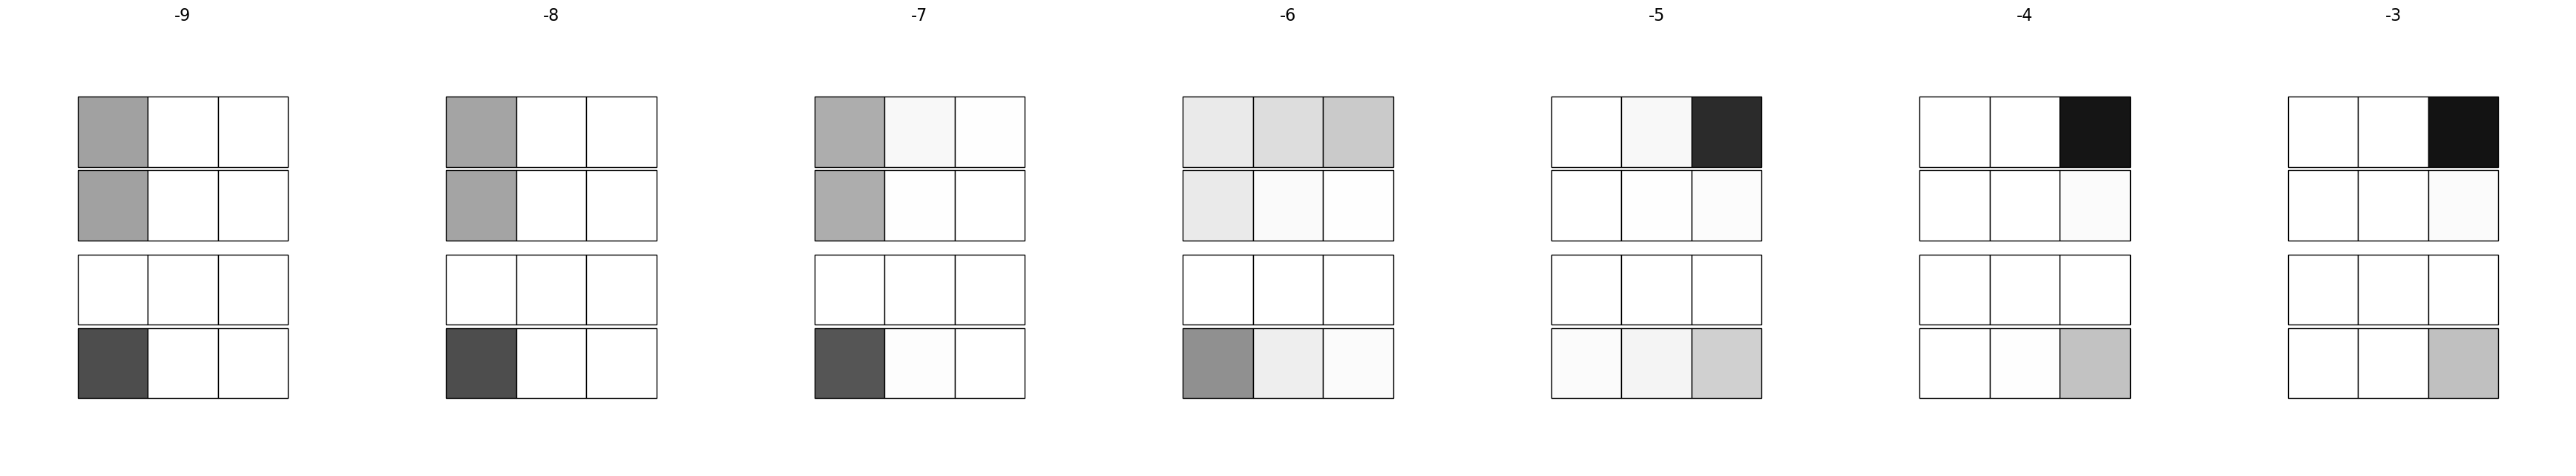

mhL


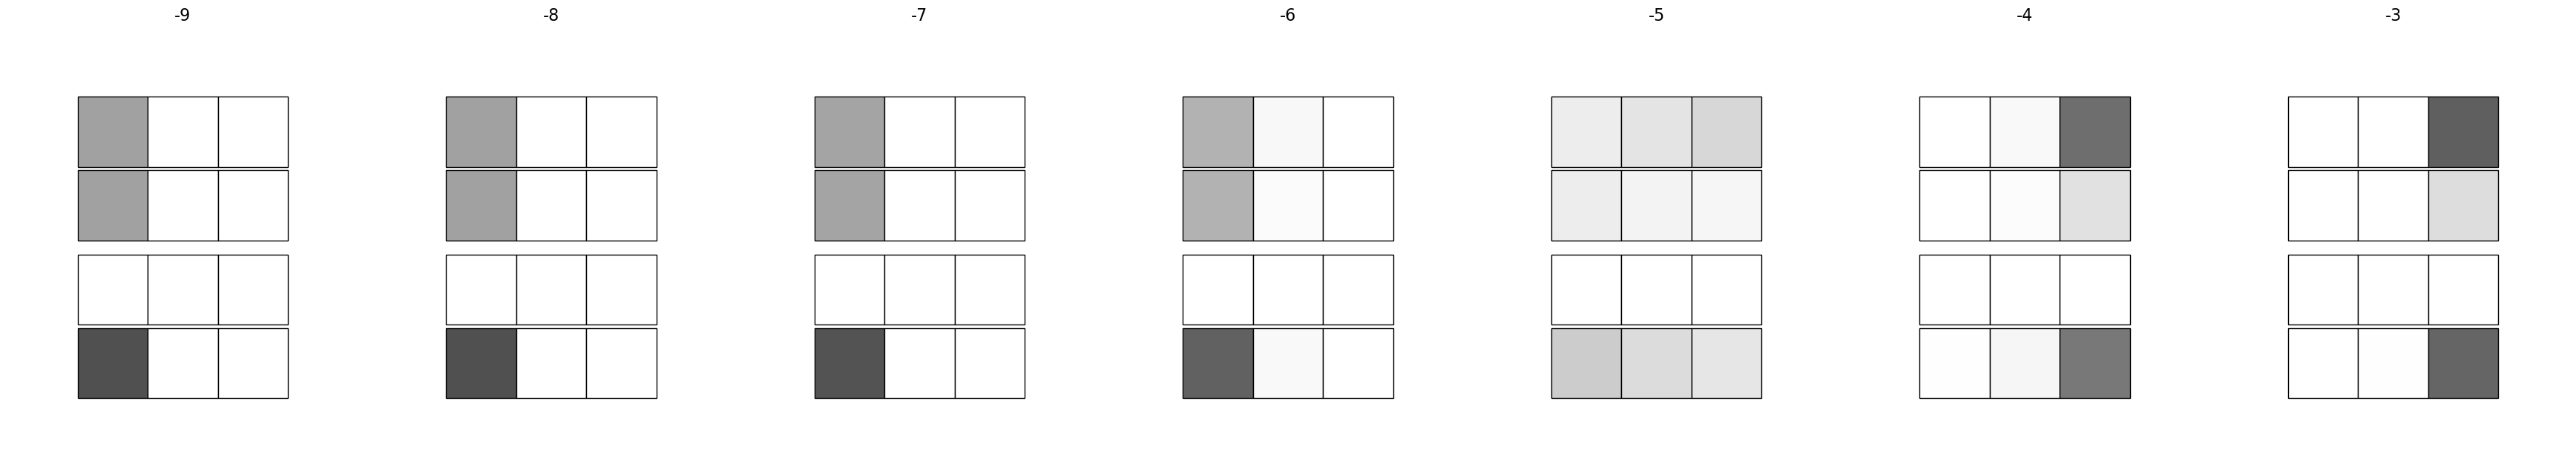

IAk


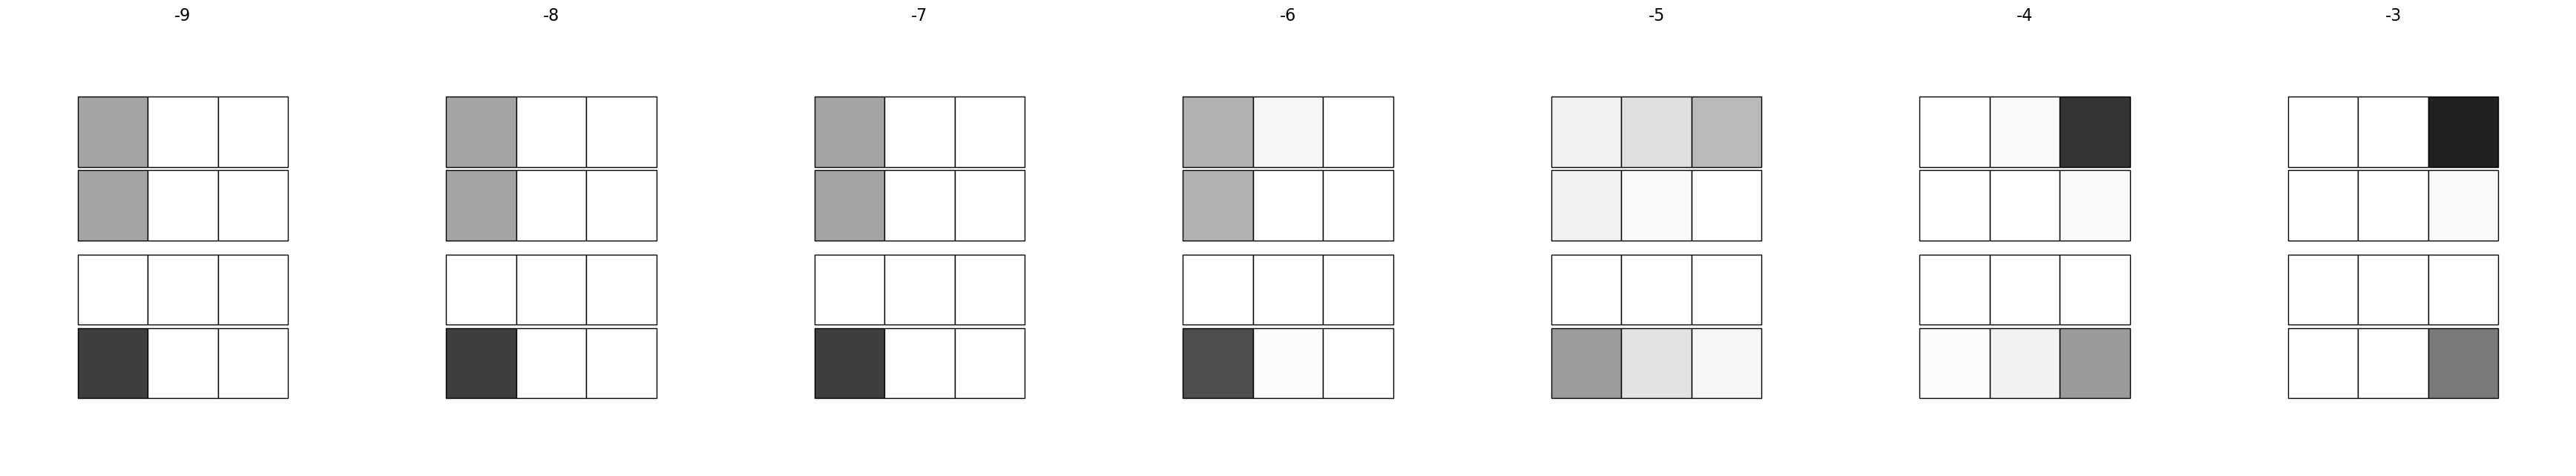

IhL


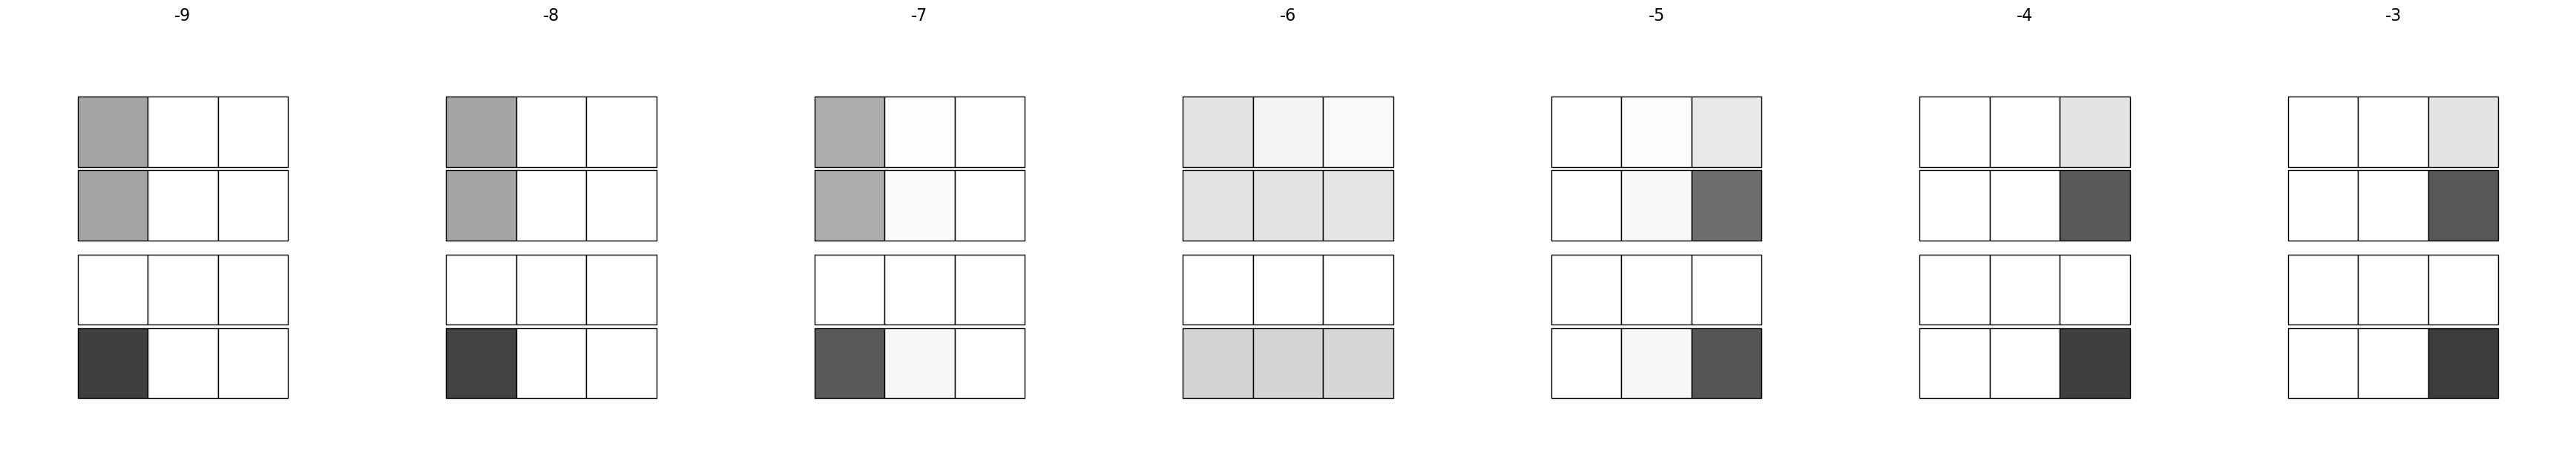

mAL


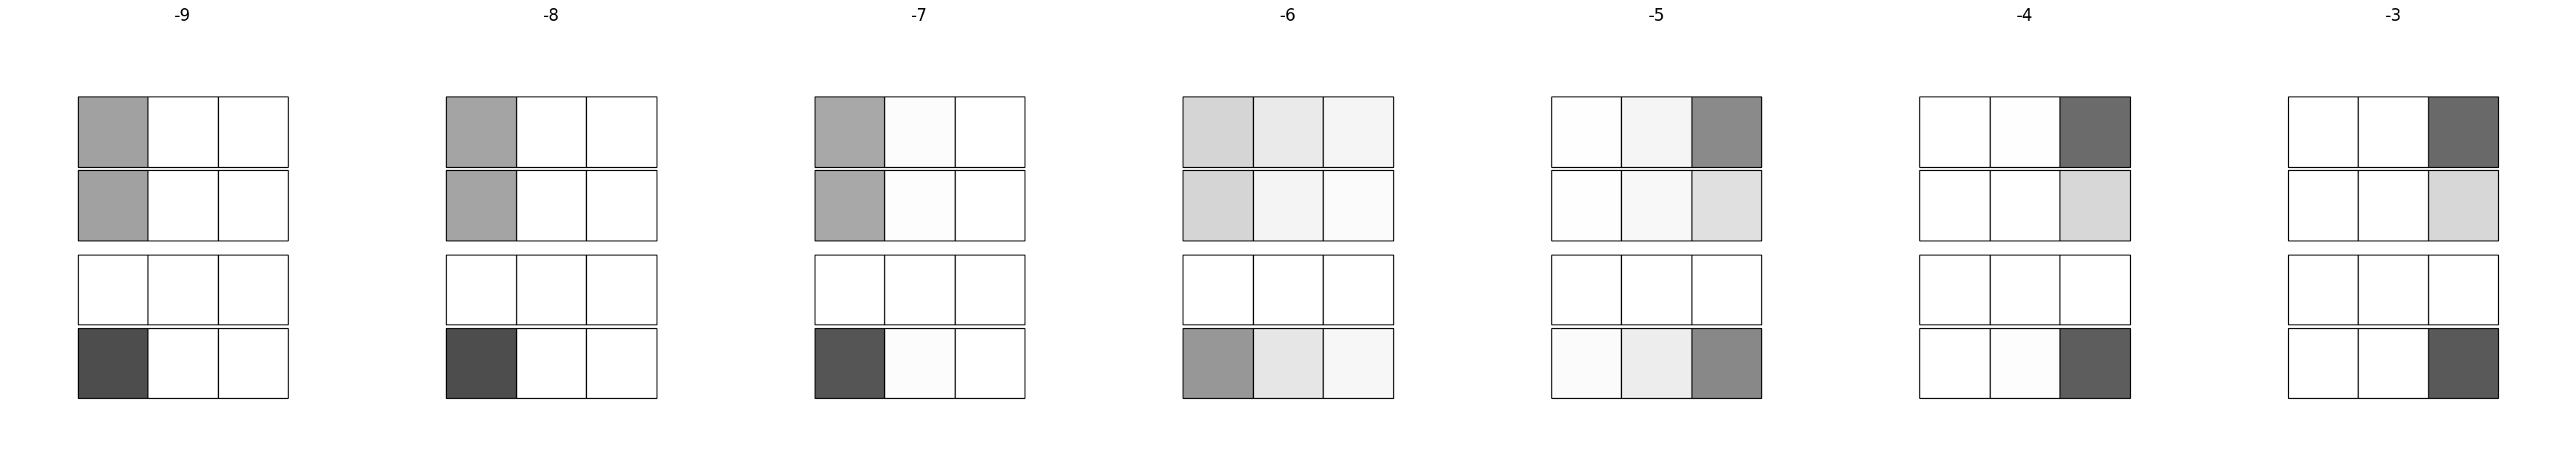

IAL


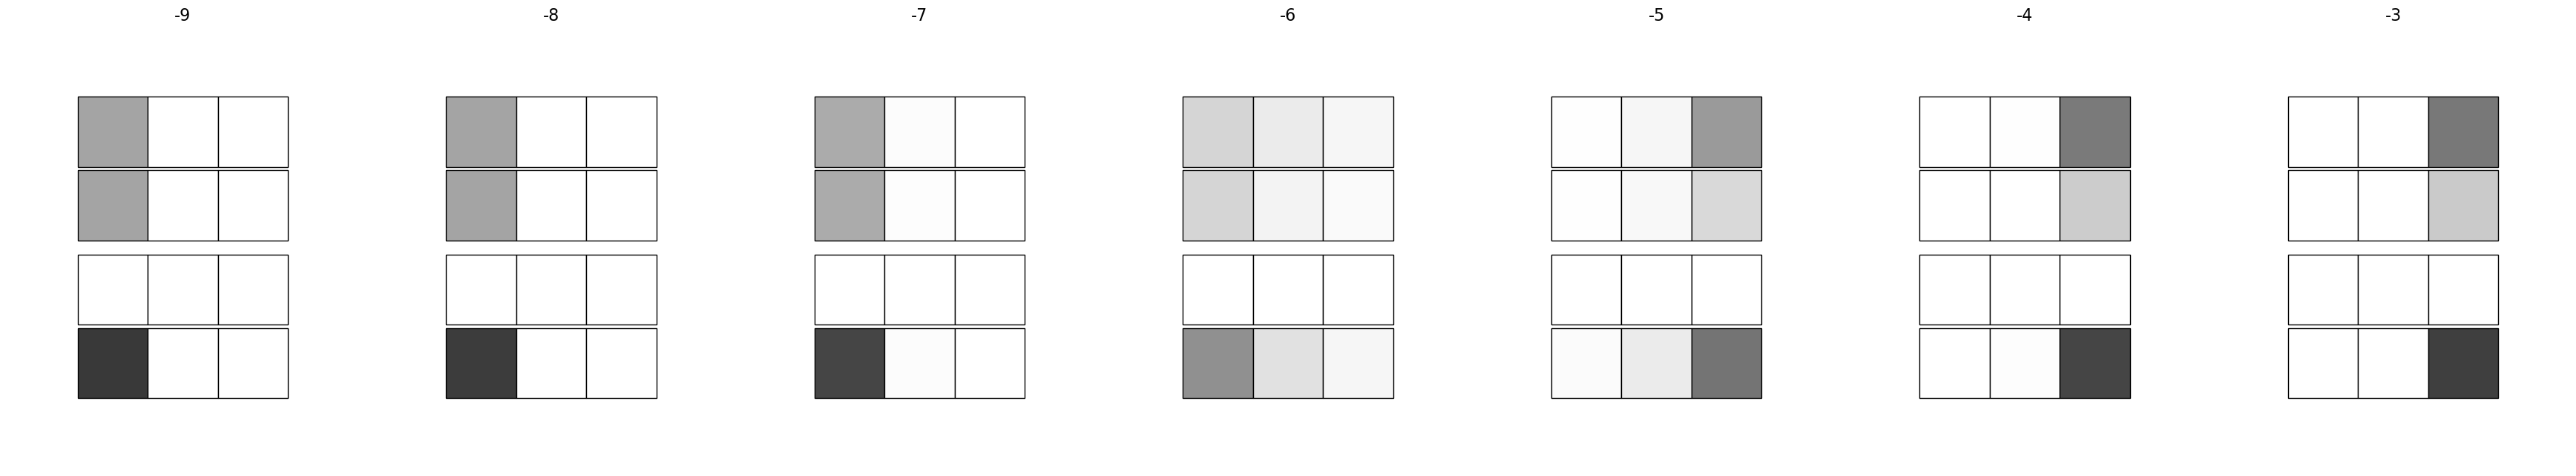

In [11]:

import matplotlib
from matplotlib import cm
from matplotlib.patches import Rectangle

color_range = [(1,1,1,1-c) for c in np.linspace(0,1,128)]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('transparent', color_range, N=100,gamma=1)
cmap = cm.get_cmap("Greys",128)

x_sep = 0.2
y_sep = 0.05
iptg_concs = [-9,-8,-7,-6,-5,-4,-3]
species = ["H",  "H.I",  "H.I_2",
           "H.O","H.O.I","H.O.I_2",
           "L",  "L.I",  "L.I_2",
           "L.O","L.O.I","L.O.I_2"]

for v in variants:
    
    print(v)
    
    df = pd.read_csv(f"fit_{model_name}/{v}_concs.csv")
    df = get_converged(df)
    df = df.loc[df.rep_converged,:]

    fig, ax = plt.subplots(1,len(iptg_concs),figsize=(5*len(iptg_concs),10))
    
    for i, conc in enumerate(iptg_concs):
        
        all_concs = df.loc[np.isclose(np.log10(df.iptg_tot),conc),species]*1e9
        all_concs = all_concs/(np.mean(df.prot_tot)*1e9)
    
        species_concs = {}
        for s in species:
            values = np.array(all_concs.loc[:,s])
            np.sort(values)
            species_concs[s] = values[len(values)//2]
            
        ax[i].add_patch(Rectangle((0,0), 1, 1,color=cmap(species_concs["H.O"]*10),ec="black"))
        ax[i].add_patch(Rectangle((1,0), 1, 1,color=cmap(species_concs["H.O.I"]*10),ec="black"))
        ax[i].add_patch(Rectangle((2,0), 1, 1,color=cmap(species_concs["H.O.I_2"]*10),ec="black"))
        ax[i].add_patch(Rectangle((0,1+y_sep), 1, 1,color=cmap(species_concs["L.O"]*10),ec="black"))
        ax[i].add_patch(Rectangle((1,1+y_sep), 1, 1,color=cmap(species_concs["L.O.I"]*10),ec="black"))
        ax[i].add_patch(Rectangle((2,1+y_sep), 1, 1,color=cmap(species_concs["L.O.I_2"]*10),ec="black"))

        ax[i].add_patch(Rectangle((0,2+y_sep+x_sep), 1, 1,color=cmap(species_concs["H"]),ec="black"))
        ax[i].add_patch(Rectangle((1,2+y_sep+x_sep), 1, 1,color=cmap(species_concs["H.I"]),ec="black"))
        ax[i].add_patch(Rectangle((2,2+y_sep+x_sep), 1, 1,color=cmap(species_concs["H.I_2"]),ec="black"))
        ax[i].add_patch(Rectangle((0,3+2*y_sep+x_sep), 1, 1,color=cmap(species_concs["L"]),ec="black"))
        ax[i].add_patch(Rectangle((1,3+2*y_sep+x_sep), 1, 1,color=cmap(species_concs["L.I"]),ec="black"))
        ax[i].add_patch(Rectangle((2,3+2*y_sep+x_sep), 1, 1,color=cmap(species_concs["L.I_2"]),ec="black"))


        ax[i].set_xlim((-1,4))
        ax[i].set_ylim((-1,5+2*y_sep+x_sep))
        ax[i].set_title(conc)

        ax[i].xaxis.set_visible(False)
        ax[i].yaxis.set_visible(False)
        for spine in ['top', 'right', 'left', 'bottom']:
            ax[i].spines[spine].set_visible(False)
        
        ax[i].set_aspect('equal', adjustable='box')

    fig.tight_layout()

    plt.show()


## Extract summaries of parameter values

### Text, Table S1

In [12]:

genotypes = ["mhk","Ihk","mAk","mhL","IAk","IhL","mAL","IAL"]
files = [f"fit_{model_name}/{g}.csv" for g in genotypes]

param_renamer = {"K_ratio":"K_DNA",
                 "K_r_e":"K_HI",
                 "K_rstar_e":"K_LI",
                 "factor":"s"}

out = {"variant":[],
       "parameter":[],
       "median":[],
       "lower":[],
       "upper":[]}
for file in files:
    variant = file.split("/")[1].split(".")[0]
    
    df = pd.read_csv(file)

    for k in df.columns:
        v = np.array(df.loc[:,k])
        if k == "factor":
            v = np.exp(v)
        else:
            v = -0.001987*(298.15 + 25)*v

        v.sort()
        L = len(v)
        median = v[L//2]
        lower = v[int(np.round(L*0.025,0))]
        upper = v[int(np.round(L*0.975,0))]

        out["variant"].append(variant)
        out["parameter"].append(param_renamer[k])
        out["median"].append(median)
        out["lower"].append(lower)
        out["upper"].append(upper)
        
df = pd.DataFrame(out)
df

,variant,parameter,median,lower,upper
0,mhk,K_DNA,0.916722,0.697165,1.116246
1,mhk,K_HI,7.758203,7.678442,7.839504
2,mhk,K_LI,5.982473,5.852190,6.105775
3,mhk,s,2.037521,1.618048,2.587428
4,Ihk,K_DNA,0.388408,0.097842,0.622962
5,Ihk,K_HI,7.509624,6.972337,7.998646
6,Ihk,K_LI,6.557908,6.064765,7.009242
7,Ihk,s,0.281754,0.201221,0.414125
8,mAk,K_DNA,2.102211,1.737710,2.411261
9,mAk,K_HI,4.922701,3.002786,6.601733


## Fits and corner plots for each genotype

### Fig 3B, Fig S1-S8

Set the apropriate genotype below (one of `"mhk","Ihk","mAk","mhL","IAk","IhL","mAL","IAL"`).


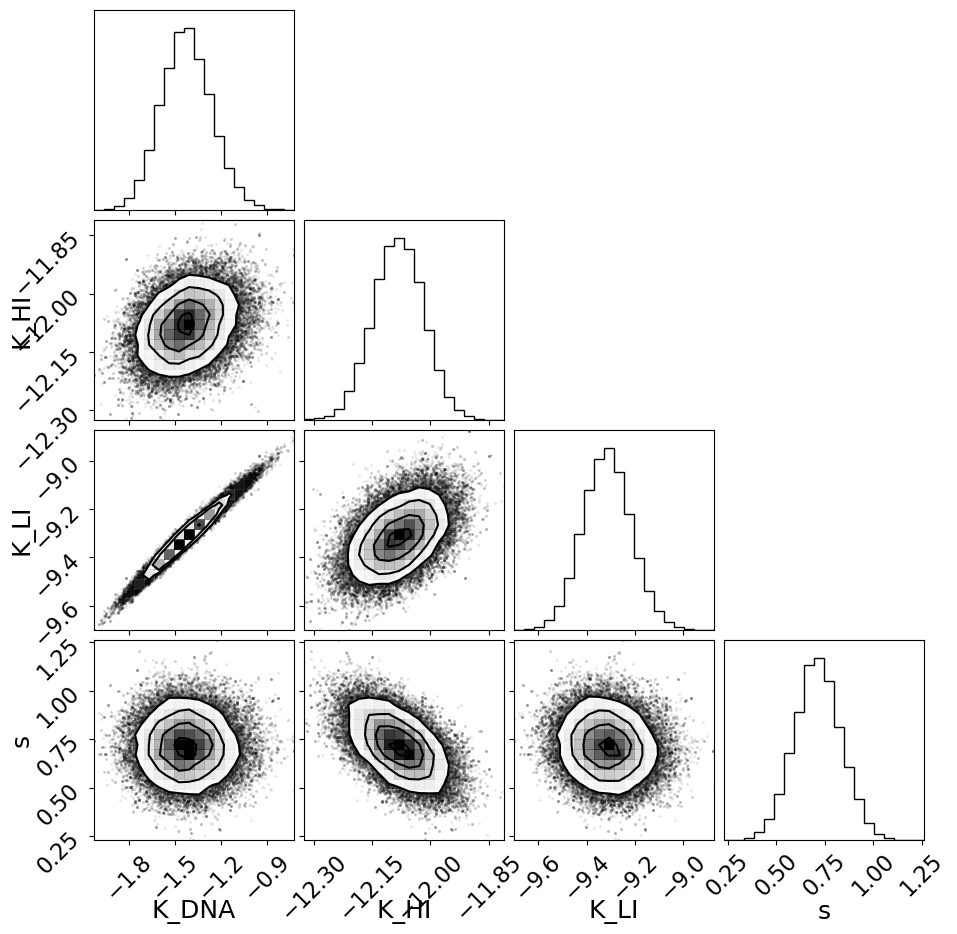

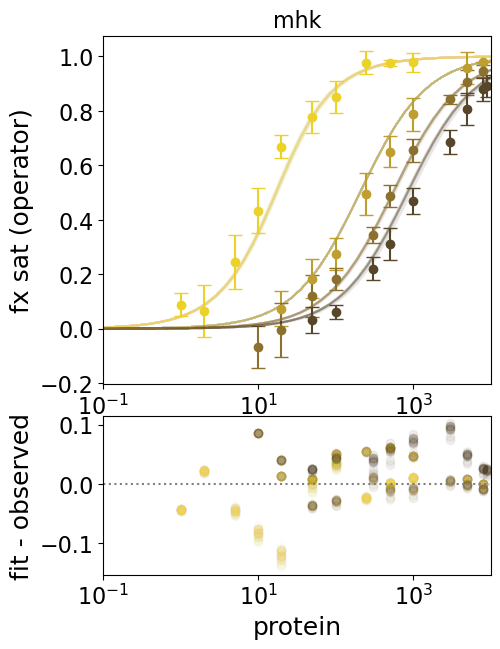

In [13]:
genotype = "mhk"



df = pd.read_csv(f"fit_3i/{genotype}.csv")  
fig = corner.corner(df,labels=["K_DNA","K_HI","K_LI","s"])

# Write fits
f = open("fit_3i/pickled-fits.pickle","rb")
fits = pickle.load(f)
f.close()

fit = fits["mhk"]
lacmwc.plot_fit(fit,num_samples=50,colors=["#ecd227","#be9e2e","#8c702e","#58462a"])


## Corner plots for different model selection fits

### Fig S9-S13

5


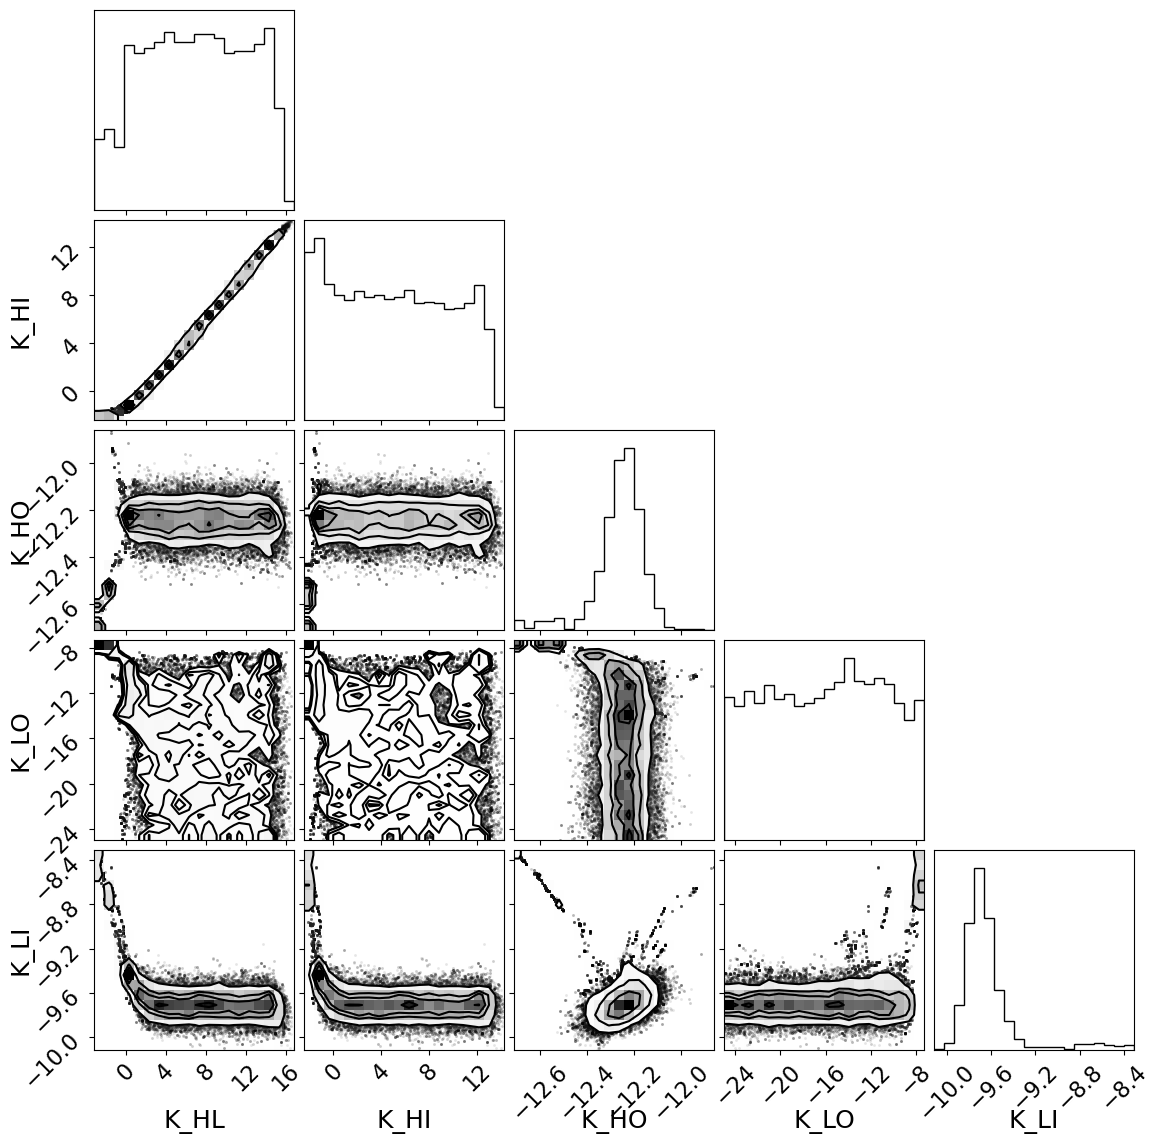

4


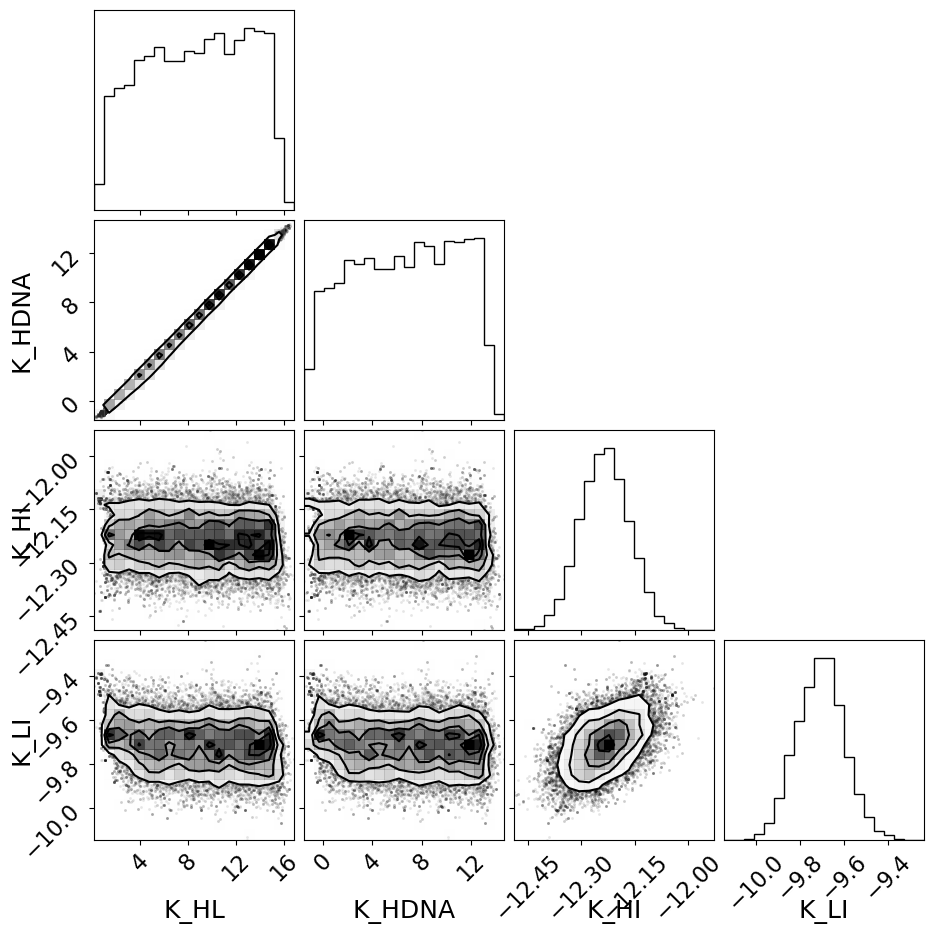

3i


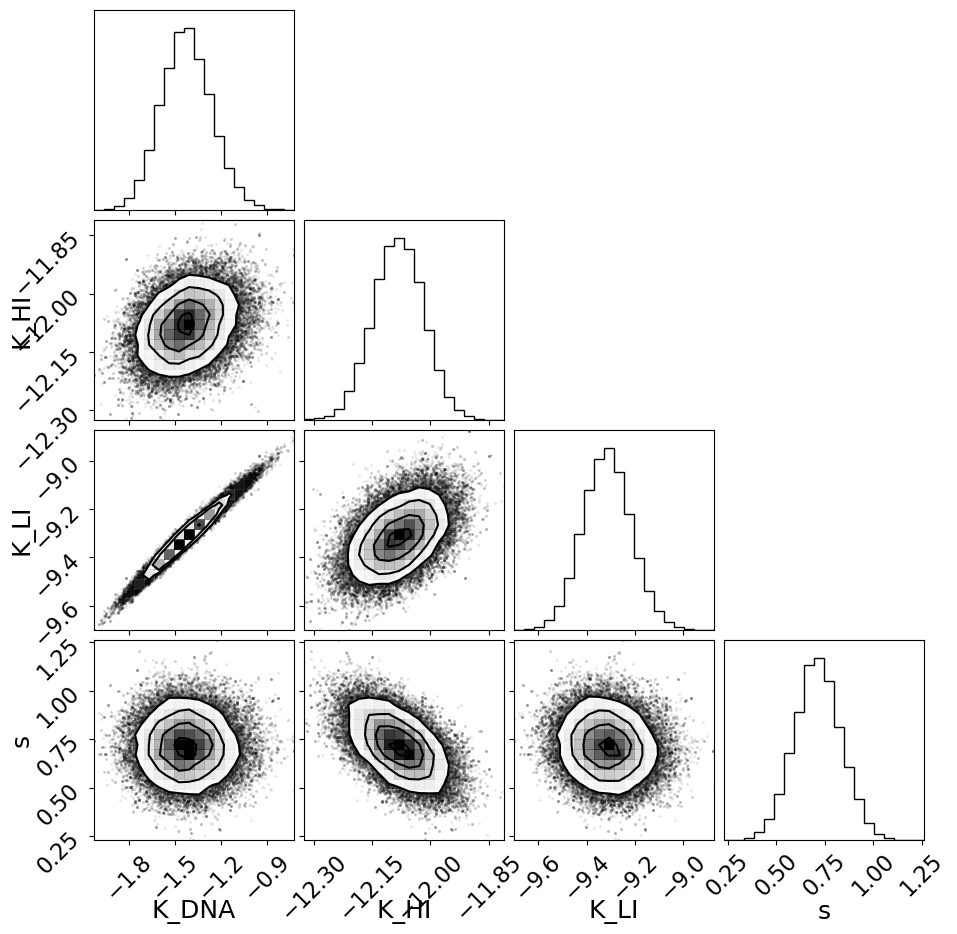

3


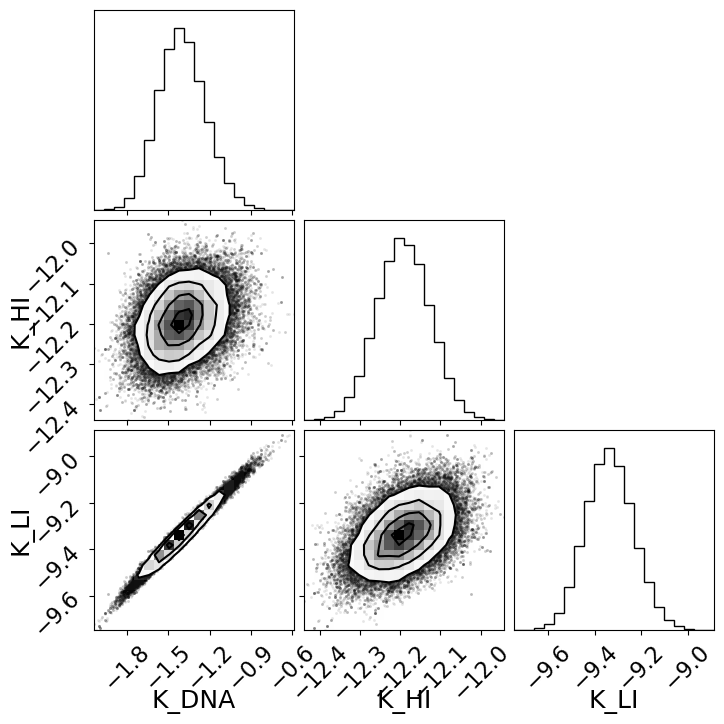

2


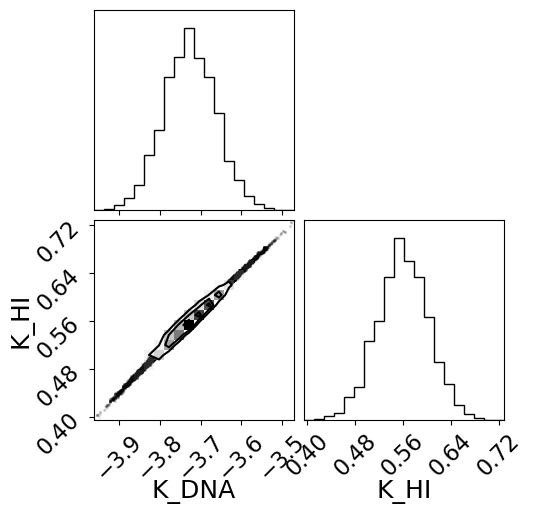

In [14]:



labels = {"2":["K_DNA","K_HI"],
          "3i":["K_DNA","K_HI","K_LI","s"],
          "3":["K_DNA","K_HI","K_LI"],
          "4":["K_HL","K_HDNA","K_HI","K_LI"],
          "5":["K_HL","K_HI","K_HO","K_LO","K_LI"]}

for m in ["5","4","3i","3","2"]:

    print(m)
    df = pd.read_csv(f"fit_{m}/mhk.csv")  
    fig = corner.corner(df,labels=labels[m])
    plt.show()

